# Patent Topic Modeling with LDA

NF: This is a very simple LDA implementation intended as a proof of concept

Our search was as follows

_class_cpc.symbol:G06N* OR class_cpc.symbol:G06T* OR class_cpc.symbol:G06V* OR class_cpc.symbol:G06F*
AND
Full Text: ( "graphics processing unit" ) OR ( Full Text: ( "compute accelerator" ) OR ( Full Text: ( "hardware scheduler" ) OR ( Full Text: ( "on-chip interconnect" ) OR ( Full Text: ( "high bandwidth memory" ) OR ( Full Text: ( "memory hierarchy" ) OR Full Text: ( "parallel processing architecture" ) ) ) ) ) )_

This pulls 38k patents. We run a quick sanity check to confirm that this was broad enough to pick up 'Tensor' related patents.  

We then use a CountVectorizer with unigrams and bigrams across the Title + Abstract of each patent. 

Run LDA with 20 topics, label these topics separately with GPT and group into broader architectural categories

---

In [199]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pathlib import Path
import re

## Step 1 — Load and Combine Text

In [208]:
# Load the patent dataset
df = pd.read_csv("../data/patents/v1_core_expansion/core/raw/sw_keyword_35000.csv")

print(f"Dataset loaded: {df.shape[0]} patents")

# Combine title + abstract for maximum signal
df["text"] = (
    df["Title"].fillna("") + ". " + df["Abstract"].fillna("")
)

# Convert to list for processing
docs = df["text"].astype(str).tolist()


Dataset loaded: 38284 patents


In [209]:
# Search for patents containing 'tensor' in their combined text (case-insensitive)
tensor_mask = df['text'].str.contains('tensor', case=False, na=False)
tensor_patents = df[tensor_mask]

print(f"Patents containing 'tensor': {len(tensor_patents)}")

if len(tensor_patents) > 0:
    # Clean up applicant names and count tensor patents by owner
    tensor_patents_clean = tensor_patents.copy()
    tensor_patents_clean['Clean_Applicant'] = (
        tensor_patents_clean['Applicants']
        .fillna('Unknown')
        .str.split(';').str[0]  # Take first applicant
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)  # Normalize whitespace
    )
    
    # Count tensor patents by applicant
    tensor_counts = tensor_patents_clean['Clean_Applicant'].value_counts()
    
    print(f"\nTop 5 owners of 'tensor' patents:")
    print("-" * 40)
    for i, (owner, count) in enumerate(tensor_counts.head(5).items(), 1):
        percentage = count / len(tensor_patents) * 100
        print(f"{i:2d}. {owner[:35]:<35} {count:3d} patents ({percentage:4.1f}%)")
    
    
    # Year distribution of tensor patents
    if 'Publication Year' in tensor_patents.columns:
        tensor_by_year = tensor_patents.groupby('Publication Year').size()
        recent_years = tensor_by_year[tensor_by_year.index >= 2018]
        if len(recent_years) > 0:
            print(f"\nRecent 'tensor' patent activity (2018+):")
            print("-" * 40)
            for year, count in recent_years.items():
                print(f"  {year}: {count} patents")
else:
    print("No patents containing 'tensor' found in the dataset")

Patents containing 'tensor': 410

Top 5 owners of 'tensor' patents:
----------------------------------------
 1. INTEL CORP                           78 patents (19.0%)
 2. QUALCOMM INC                         58 patents (14.1%)
 3. GOOGLE LLC                           40 patents ( 9.8%)
 4. MICROSOFT TECHNOLOGY LICENSING LLC   38 patents ( 9.3%)
 5. NVIDIA CORP                          38 patents ( 9.3%)

Recent 'tensor' patent activity (2018+):
----------------------------------------
  2018: 19 patents
  2019: 21 patents
  2020: 34 patents
  2021: 36 patents
  2022: 58 patents
  2023: 73 patents
  2024: 85 patents
  2025: 67 patents


## Step 2 — Remove Patent + GPU Boilerplate

In [202]:
# Patent-specific stopwords to remove boilerplate language
custom_stopwords = [
    # Patent boilerplate
    "method", "apparatus", "system", "device", "devices",
    "plurality", "configured", "embodiment", "embodiments",
    "thereof", "wherein", "said", "may", "can", "could",
    "include", "includes", "including", "comprise", "comprises",
    "using", "use", "used", "application", "invention",
    "present", "disclosed", "described", "provided",
    "according", "various", "one", "two", "first", "second",
    "particular", "specific", "certain", "example", "examples",
    "figure", "figures", "shown", "illustrated",

    # Generic GPU identity terms (remove to expose substructure)
    "gpu", "gpus",
    "graphics", "graphic",
    "graphics processing",
    "figure", "figures",
    "fig", "figs",
    "shown", "illustrated", "illustrates", "illustrating",
    "depicted", "depicts", "depicting",
    "displayed", "displaying",
    "diagram", "diagrams",
    "drawing", "drawings",
    "chart", "charts",
    "graph", "graphs",
    "schematic", "schematics",
    "block", "block diagram", "block diagrams",
    "flowchart", "flowcharts",
    "flow", "flow diagram", "flow diagrams",

    # Generic computing noise
    "based", "multiple", "parallel",
    "computing", "compute",
    "data", "information",
    "execution", "executing",
    "command", "commands",
    "program", "programs",
    "instruction", "instructions",
    "thread", "threads",
    "processor", "processors"
]

more_patent_stopwords = [
    # super-common patent/claim glue
    "methods", "systems",
    "technique", "techniques",
    "provide", "provides", "providing",
    "perform", "performs", "performing",
    "receive", "receives", "receiving",
    "associated", "based",
    "comprising", "having",
    "disclosure", "describes", "describe",
    "sets", "forth",

    # generic sectioning words (often dominate)
    "aspects", "aspect",
    "implementation", "implementations",
    "example", "examples",
    "various",

    # generic nouns that add little signal in patents
    "operations", "operation",
    "process", "processes", "processing",
    "module", "modules",
    "component", "components",
    "elements", "element",
    "structure", "structures",

    # often unhelpful “quantifier” words in patents
    "different", "number", "set", "sets",
    "low", "high",  # keep if you care about performance tiers; otherwise remove
]

custom_stopwords.extend(more_patent_stopwords)


print(f"Custom stopwords defined: {len(custom_stopwords)} terms")
print("Sample stopwords:", custom_stopwords[:10])

Custom stopwords defined: 147 terms
Sample stopwords: ['method', 'apparatus', 'system', 'device', 'devices', 'plurality', 'configured', 'embodiment', 'embodiments', 'thereof']


## Step 3 — Vectorize Text

In [ ]:
# Create TF-IDF vectorizer with patent-specific preprocessing
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer

# Combine English stopwords with our custom patent stopwords
all_stopwords = list(ENGLISH_STOP_WORDS.union(set(custom_stopwords)))


vectorizer = CountVectorizer(
    stop_words=all_stopwords,
    max_df=0.4,
    min_df=10,
    ngram_range=(1, 2),
    lowercase=True,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z0-9_]{1,}\b"  
)

# Fit and transform the documents
X = vectorizer.fit_transform(docs)

print(f"Vocabulary size: {X.shape[1]} terms")
print(f"Document-term matrix shape: {X.shape}")
print(f"Sparsity: {(1 - X.nnz / (X.shape[0] * X.shape[1])):.1%}")
print(f"Total stopwords used: {len(all_stopwords)}")

Vocabulary size: 26006 terms
Document-term matrix shape: (38284, 26006)
Sparsity: 99.9%
Total stopwords used: 447


## Step 4 — Fit LDA Model

In [204]:
# Set number of topics (start with 10, adjust based on results)
n_topics = 20

# Fit LDA model
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch",        # More stable than online for smaller datasets
    max_iter=100,                  # Increase if convergence issues
    doc_topic_prior=0.1,           # Alpha: lower = sparser topic distributions
    topic_word_prior=0.01          # Beta: lower = sparser topics
)

print("Fitting LDA model...")
lda.fit(X)

# Transform documents to get topic distributions
doc_topic_dist = lda.transform(X)

print(f"LDA fitted with {n_topics} topics")
print(f"Document-topic distribution shape: {doc_topic_dist.shape}")
print(f"Each row contains P(topic_i | document) for topics 0-{n_topics-1}")
print("Avg max topic weight:", doc_topic_dist.max(axis=1).mean())


# Check convergence
print(f"Final log-likelihood: {lda.score(X):.2f}")

Fitting LDA model...


KeyboardInterrupt: 

## Step 5 — Attach Topic Distribution to DataFrame

In [ ]:
# Add topic probabilities to the original dataframe
for i in range(n_topics):
    df[f"topic_{i}"] = doc_topic_dist[:, i]

# Save enhanced dataset with topic distributions
output_path = "../data/patents/v1_core_expansion/core/parsed/patents_with_topics.csv"
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path, index=False)

print(f"Enhanced dataset saved to: {output_path}")
print(f"New columns added: topic_0 through topic_{n_topics-1}")

# Show sample of topic distributions
print("\nSample topic distributions:")
topic_cols = [f"topic_{i}" for i in range(n_topics)]
print(df[["Title"] + topic_cols].head(3))

Enhanced dataset saved to: ../data/patents/v1_core_expansion/core/parsed/patents_with_topics.csv
New columns added: topic_0 through topic_19

Sample topic distributions:
                                               Title   topic_0   topic_1  \
0  ANCHORING VIRTUAL IMAGES TO REAL WORLD SURFACE...  0.012854  0.000901   
1  SYSTEMS AND METHODS FOR SAFE AND RELIABLE AUTO...  0.099918  0.027306   
2  EFFICIENT DUPLICATE DETECTION FOR MACHINE LEAR...  0.001667  0.001667   

    topic_2   topic_3   topic_4   topic_5   topic_6   topic_7   topic_8  ...  \
0  0.000901  0.000901  0.000901  0.000901  0.406626  0.063851  0.000901  ...   
1  0.000918  0.329335  0.000918  0.000918  0.075838  0.000918  0.000918  ...   
2  0.001667  0.001667  0.090548  0.141107  0.001667  0.001667  0.001667  ...   

   topic_10  topic_11  topic_12  topic_13  topic_14  topic_15  topic_16  \
0  0.000901  0.000901  0.149161  0.000901  0.313204  0.000901  0.000901   
1  0.000918  0.000918  0.000918  0.000918  0.000918  0

## Step 6 — Interpret Topics (Critical)

Understanding what each topic represents through its top words.

In [ ]:
# Extract and display top words for each topic
import numpy as np
topic_share = doc_topic_dist.mean(axis=0)
print(np.round(topic_share, 3))
print("min/max share:", topic_share.min(), topic_share.max())

feature_names = vectorizer.get_feature_names_out()

print("=" * 60)
print("TOPIC INTERPRETATION")
print("=" * 60)

topic_summaries = {}

for topic_idx, topic in enumerate(lda.components_):
    # Get top 15 words for this topic
    top_word_indices = topic.argsort()[-15:][::-1]  # Sort descending
    top_words = [feature_names[i] for i in top_word_indices]
    top_weights = [topic[i] for i in top_word_indices]
    
    topic_summaries[topic_idx] = top_words
    
    print(f"\nTopic {topic_idx}:")
    print(", ".join(top_words))
    print(f"(Weights: {[f'{w:.3f}' for w in top_weights[:5]]})")

# Save topic summaries
import json
topics_output_path = "../data/patents/v1_core_expansion/core/parsed/topic_summaries.json"
with open(topics_output_path, 'w') as f:
    json.dump(topic_summaries, f, indent=2)
    
print(f"\nTopic summaries saved to: {topics_output_path}")

[0.042 0.071 0.042 0.04  0.061 0.053 0.082 0.05  0.033 0.05  0.05  0.035
 0.032 0.048 0.047 0.065 0.038 0.056 0.069 0.035]
min/max share: 0.03156049679432296 0.082479976104088
TOPIC INTERPRETATION

Topic 0:
task, time, tasks, scheduling, work, workload, cluster, priority, job, performance, scheduler, workloads, member, schedule, profile
(Weights: ['4618.794', '2808.777', '2098.715', '1894.842', '1627.340'])

Topic 1:
memory, access, unit, circuit, controller, memory memory, shared, memory controller, coupled, memory access, chip, local, integrated, cpu, die
(Weights: ['36624.074', '2904.911', '2806.222', '2608.956', '2005.842'])

Topic 2:
input, vector, output, matrix, value, circuit, values, array, signal, weight, vectors, result, corresponding, generate, convolution
(Weights: ['8084.409', '5412.691', '5271.741', '3757.248', '3455.531'])

Topic 3:
compression, compressed, blocks, prefetch, value, size, threshold, pattern, values, metadata, bits, decompression, determined, length, vari

In [ ]:
# Topic 0: Workload Scheduling & QoS
# Topic 1: Memory Controller & On-Chip Integration
# Topic 2: Matrix / Vector Compute Circuits
# Topic 3: Compression & Prefetch Logic
# Topic 4: Core Execution & Register Logic
# Topic 5: Neural Network Acceleration
# Topic 6: Vision & Image Processing
# Topic 7: Graphics Rendering Pipeline
# Topic 8: Floating-Point & Precision Units
# Topic 9: Power & Performance States
# Topic 10: Host Interface & Storage I/O
# Topic 11: Virtual Memory & Address Translation
# Topic 12: Video Streaming & Virtual Contexts
# Topic 13: Cache Hierarchy & Ray Tracing
# Topic 14: Display & User Interface Control
# Topic 15: Machine Learning Models
# Topic 16: Resource Allocation & Tensor Management
# Topic 17: User Interaction & Search Interfaces
# Topic 18: GPU Virtualization & Accelerators
# Topic 19: Shader & Geometry Processing



# 1. Memory & Data Movement Architecture (Topic 1, Topic 3, Topic 10, Topic 11, Topic 13)

# 2. Compute Core & Execution Microarchitecture (Topic 2, Topic 4, Topic 8)

# 3. Graphics & Rendering Pipeline (Topic 7, Topic 19)

# 4. AI & Machine Learning Acceleration (Topic 5, Topic 6, Topic 15)

# 5. Virtualization & Platform Infrastructure (Topic 12, Topic 18)

# 6. System Scheduling & Resource Management (Topic 0, Topic 16)

# 7. Power, Display & External Interfaces (Topic 9, Topic 14)

# 8. User-Facing & Application-Level Systems (Topic 17)




## Topic Evolution Over Time

Visualize how topic distributions change across publication years to identify patent trends and technology evolution in GPU hardware.

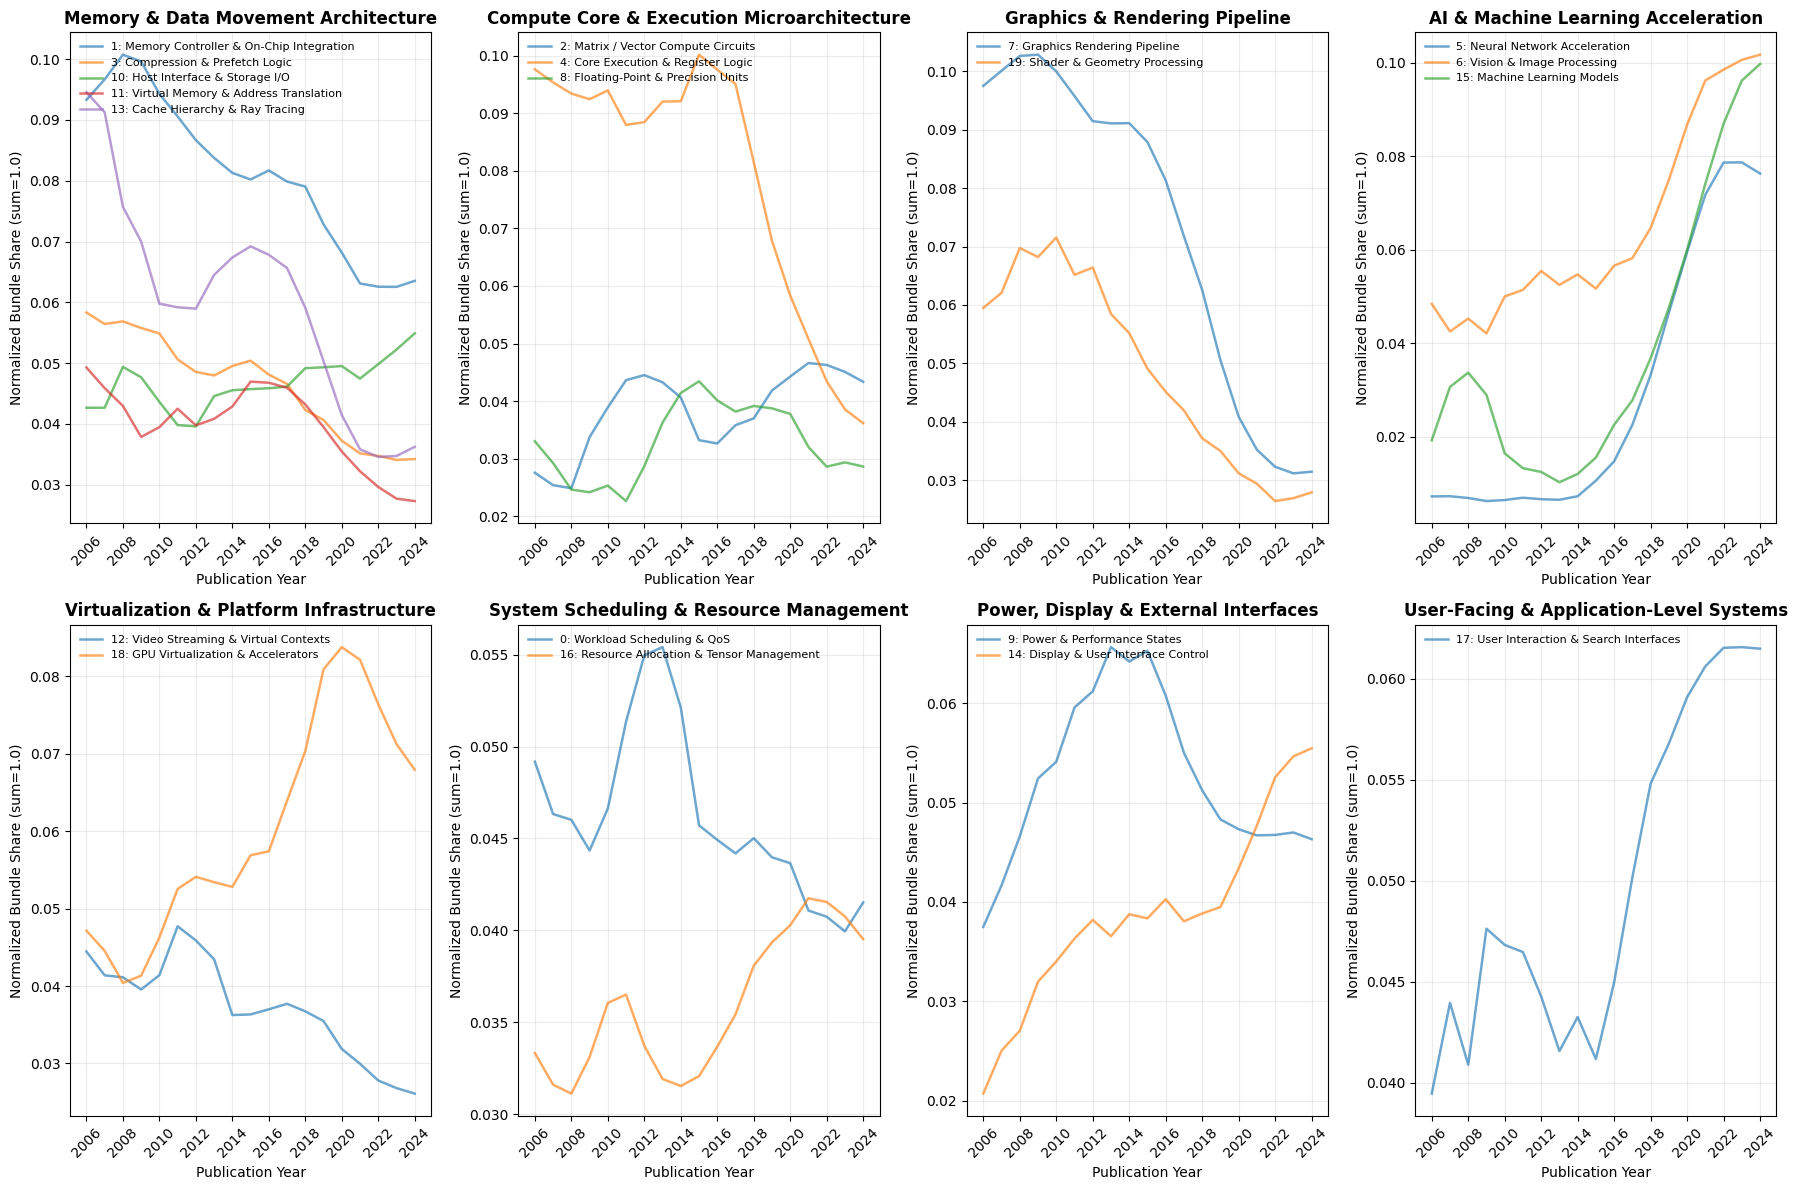

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')

# ---------------------------------------
# Topic labels + macro-domain groupings
# ---------------------------------------
topic_labels = {
    0: "Workload Scheduling & QoS",
    1: "Memory Controller & On-Chip Integration",
    2: "Matrix / Vector Compute Circuits",
    3: "Compression & Prefetch Logic",
    4: "Core Execution & Register Logic",
    5: "Neural Network Acceleration",
    6: "Vision & Image Processing",
    7: "Graphics Rendering Pipeline",
    8: "Floating-Point & Precision Units",
    9: "Power & Performance States",
    10: "Host Interface & Storage I/O",
    11: "Virtual Memory & Address Translation",
    12: "Video Streaming & Virtual Contexts",
    13: "Cache Hierarchy & Ray Tracing",
    14: "Display & User Interface Control",
    15: "Machine Learning Models",
    16: "Resource Allocation & Tensor Management",
    17: "User Interaction & Search Interfaces",
    18: "GPU Virtualization & Accelerators",
    19: "Shader & Geometry Processing"
}

topic_bundles = {
    "Memory & Data Movement Architecture": [1, 3, 10, 11, 13],
    "Compute Core & Execution Microarchitecture": [2, 4, 8],
    "Graphics & Rendering Pipeline": [7, 19],
    "AI & Machine Learning Acceleration": [5, 6, 15],
    "Virtualization & Platform Infrastructure": [12, 18],
    "System Scheduling & Resource Management": [0, 16],
    "Power, Display & External Interfaces": [9, 14],
    "User-Facing & Application-Level Systems": [17]
}


# ----------------------------
# Filter
# ----------------------------
df_filtered = df[((df["Publication Year"] >= 2006) & (df["Publication Year"] <= 2024))].copy()
topic_cols = [f"topic_{i}" for i in range(n_topics)]

# patents/year (for context)
patents_per_year = df_filtered.groupby("Publication Year").size()

# ----------------------------
# Choose normalization
# ----------------------------
USE_SHARES = False  # True => composition; False => intensity per patent
WINDOW = 3          # smoothing window in years
TOP_K = None        # e.g., 3 to show only top 3 topics per bundle, or None to show all

if USE_SHARES:
    yearly_topic_sums = df_filtered.groupby("Publication Year")[topic_cols].sum()
    yearly = yearly_topic_sums.div(yearly_topic_sums.sum(axis=1), axis=0)  # each year sums to 1
    y_label = "Topic Share (fraction of topic mass)"
else:
    yearly = df_filtered.groupby("Publication Year")[topic_cols].mean()
    y_label = "Normalized Bundle Share (sum=1.0)"

# Smooth to reduce noise
yearly_sm = yearly.rolling(window=WINDOW, center=True, min_periods=1).mean()

# ----------------------------
# Plot
# ----------------------------
fig, axes = plt.subplots(2, 4, figsize=(18, 12))
axes = axes.flatten()

years = yearly_sm.index.values

# pick sparser x ticks
tick_step = 2
xticks = years[::tick_step]

for idx, (bundle_name, topics) in enumerate(topic_bundles.items()):
    ax = axes[idx]

    # Optionally select TOP_K topics within this bundle (by average level across time)
    topics_to_plot = topics
    if TOP_K is not None and TOP_K < len(topics):
        avg_levels = {t: yearly_sm[f"topic_{t}"].mean() for t in topics}
        topics_to_plot = sorted(avg_levels, key=avg_levels.get, reverse=True)[:TOP_K]

    # Calculate normalization factor for all bundles
    all_bundle_totals = pd.DataFrame()
    for bundle_name_norm, topics_norm in topic_bundles.items():
        bundle_cols_norm = [f"topic_{t}" for t in topics_norm]
        all_bundle_totals[bundle_name_norm] = yearly_sm[bundle_cols_norm].sum(axis=1)
    
    bundle_row_sums = all_bundle_totals.sum(axis=1)
    bundle_row_sums = bundle_row_sums.replace(0, 1)  # Avoid division by zero

    # Plot each topic (smoothed and normalized)
    for topic_id in topics_to_plot:
        topic_values_normalized = yearly_sm[f"topic_{topic_id}"] / bundle_row_sums
        ax.plot(
            years,
            topic_values_normalized.values,
            linewidth=1.8,
            alpha=0.65,
            label=f"{topic_id}: {topic_labels.get(topic_id, 'Unknown')}",
        )

    ax.set_title(bundle_name, fontsize=12, fontweight="bold")
    ax.set_xlabel("Publication Year")
    ax.set_ylabel(y_label)
    ax.grid(True, alpha=0.25)

    ax.set_xticks(xticks)
    ax.tick_params(axis="x", rotation=45)

    # Cleaner legend placement
    ax.legend(fontsize=8, loc="upper left", frameon=False)

plt.tight_layout()
plt.show()

Using topic weight threshold: 0.35
A patent counts in a bundle if any topic in that bundle has weight >= 0.35


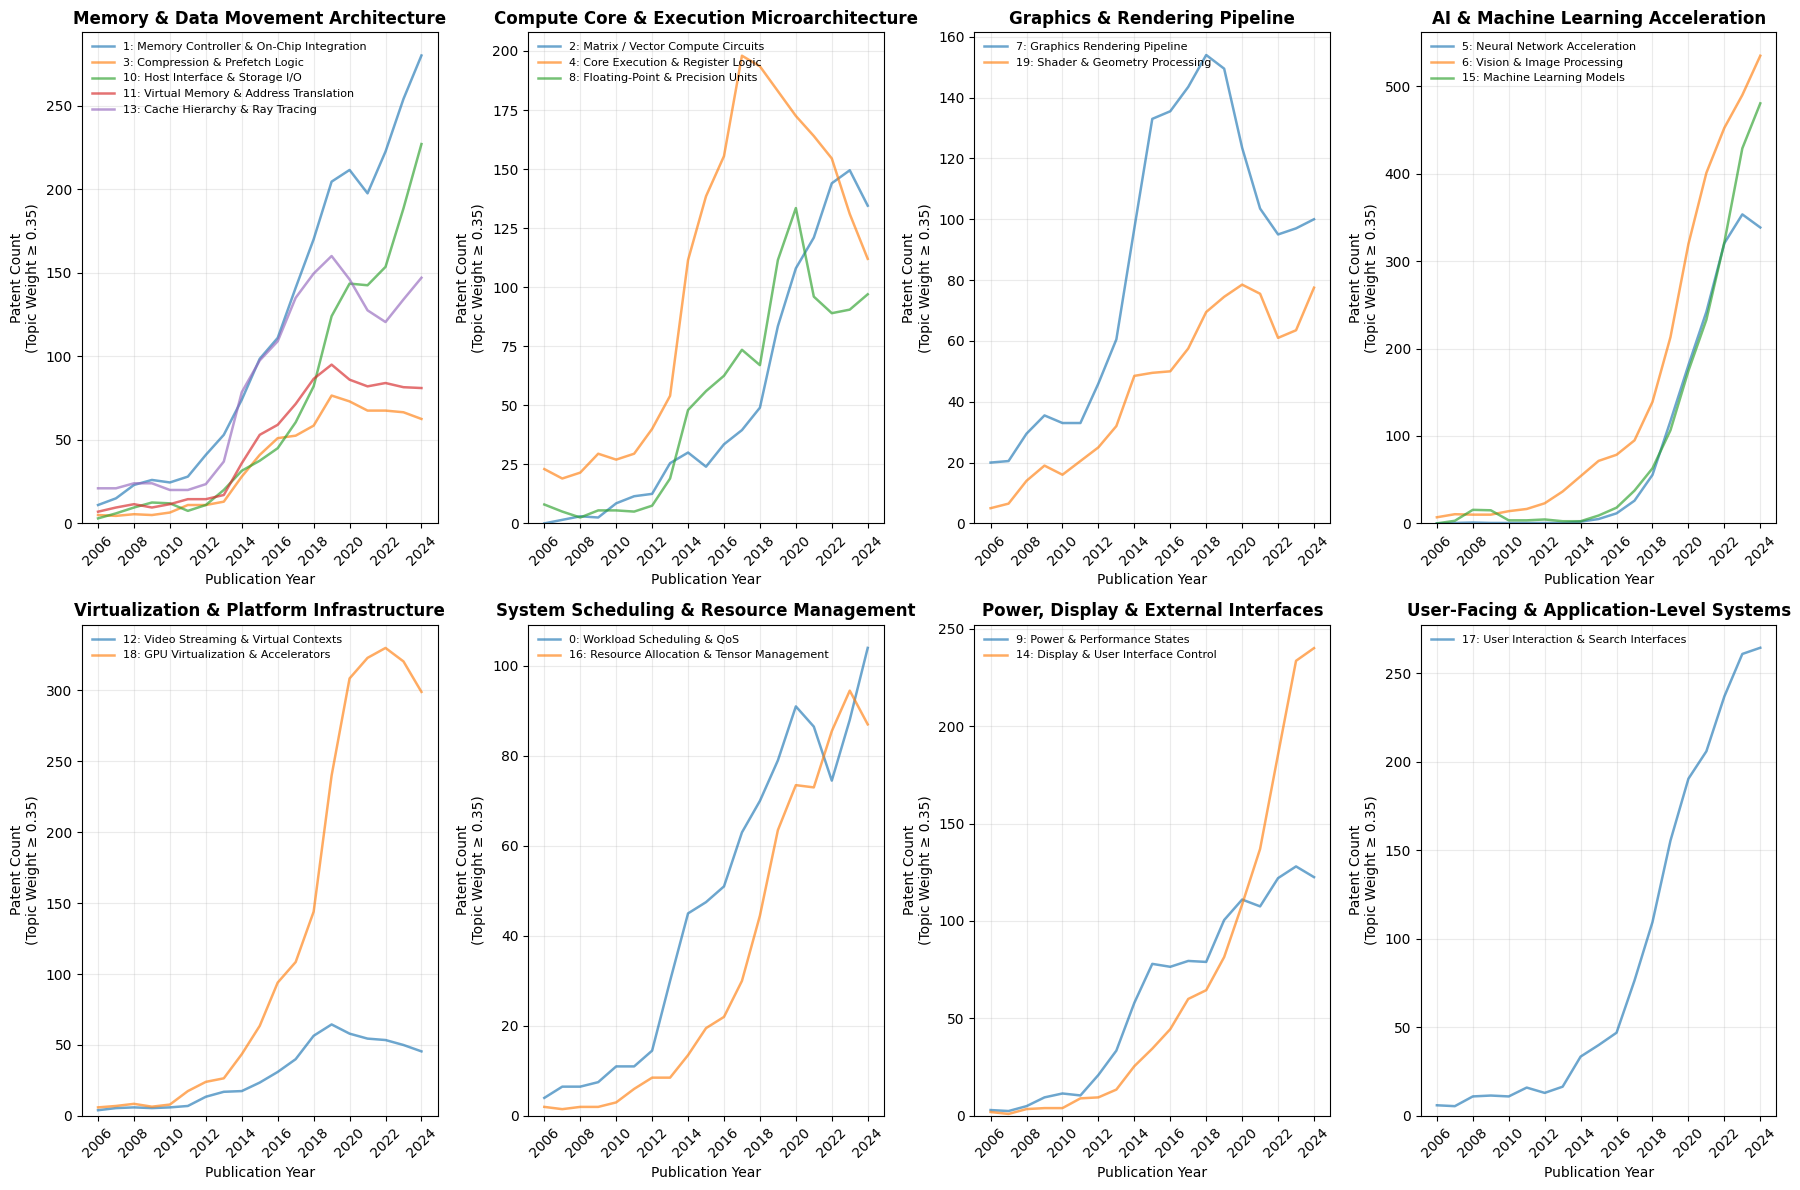

In [212]:
# Bundle Evolution Over Time (Patent Counts, Excluding AI/ML)
# Count patents with topic weight >= 0.35 in each bundle

fig, axes = plt.subplots(2, 4, figsize=(18, 12))
axes = axes.flatten()

# Filter data for analysis
years = df_filtered["Publication Year"].unique()
years = years[years <= 2024]  # Cut off at 2024
years.sort()

# Patent count threshold
TOPIC_THRESHOLD = 0.35

print(f"Using topic weight threshold: {TOPIC_THRESHOLD}")
print(f"A patent counts in a bundle if any topic in that bundle has weight >= {TOPIC_THRESHOLD}")

for idx, (bundle_name, topics) in enumerate(topic_bundles.items()):
    ax = axes[idx]
    
    # Calculate patent counts for each year and each topic in this bundle
    yearly_counts = []
    yearly_bundle_counts = []
    
    for year in years:
        year_data = df_filtered[df_filtered["Publication Year"] == year]
        year_counts_per_topic = {}
        
        # Count patents for each topic in this bundle
        for topic_id in topics:
            topic_col = f"topic_{topic_id}"
            patents_above_threshold = (year_data[topic_col] >= TOPIC_THRESHOLD).sum()
            year_counts_per_topic[topic_id] = patents_above_threshold
        
        yearly_counts.append(year_counts_per_topic)
        
        # Count patents in this bundle (any topic >= threshold)
        bundle_topic_cols = [f"topic_{t}" for t in topics]
        bundle_mask = (year_data[bundle_topic_cols] >= TOPIC_THRESHOLD).any(axis=1)
        yearly_bundle_counts.append(bundle_mask.sum())

    # Plot individual topics
    for topic_id in topics:
        topic_counts = [year_counts[topic_id] for year_counts in yearly_counts]
        
        # Apply light smoothing to reduce noise
        topic_counts_series = pd.Series(topic_counts, index=years)
        topic_counts_smoothed = topic_counts_series.rolling(window=2, center=True, min_periods=1).mean()
        
        ax.plot(
            years,
            topic_counts_smoothed.values,
            linewidth=1.8,
            alpha=0.65,
            label=f"{topic_id}: {topic_labels.get(topic_id, 'Unknown')}",
        )

    ax.set_title(bundle_name, fontsize=12, fontweight="bold")
    ax.set_xlabel("Publication Year")
    ax.set_ylabel(f"Patent Count\n(Topic Weight ≥ {TOPIC_THRESHOLD})")
    ax.grid(True, alpha=0.25)

    # Format x-axis
    tick_step = 2
    xticks = years[::tick_step]
    ax.set_xticks(xticks)
    ax.tick_params(axis="x", rotation=45)
    
    # Set y-axis to start from 0
    ax.set_ylim(bottom=0)

    # Legend placement
    ax.legend(fontsize=8, loc="upper left", frameon=False)



plt.tight_layout()
plt.show()



for bundle_name, topics in topic_bundles.items():    
    # Calculate total patents across all years for this bundle
    bundle_topic_cols = [f"topic_{t}" for t in topics]
    bundle_mask = (df_filtered[bundle_topic_cols] >= TOPIC_THRESHOLD).any(axis=1)
    total_patents_in_bundle = bundle_mask.sum()
    
    # Calculate individual topic totals
    topic_totals = {}
    for topic_id in topics:
        topic_col = f"topic_{topic_id}"
        topic_total = (df_filtered[topic_col] >= TOPIC_THRESHOLD).sum()
        topic_totals[topic_id] = topic_total
    
    for topic_id, total in topic_totals.items():
        percentage = (total / len(df_filtered)) * 100
    
    # Calculate recent trend (last 5 years vs first 5 years) using sum/topics approach
    recent_years = years[-5:]
    early_years = years[:5]
    
    recent_data = df_filtered[df_filtered["Publication Year"].isin(recent_years)]
    early_data = df_filtered[df_filtered["Publication Year"].isin(early_years)]
    
    # Calculate average trend value for recent and early periods
    recent_trend_values = []
    for year in recent_years:
        year_data = df_filtered[df_filtered["Publication Year"] == year]
        total_topic_patents = 0
        for topic_id in topics:
            topic_col = f"topic_{topic_id}"
            total_topic_patents += (year_data[topic_col] >= TOPIC_THRESHOLD).sum()
        trend_value = total_topic_patents / len(topics)
        recent_trend_values.append(trend_value)
    
    early_trend_values = []
    for year in early_years:
        year_data = df_filtered[df_filtered["Publication Year"] == year]
        total_topic_patents = 0
        for topic_id in topics:
            topic_col = f"topic_{topic_id}"
            total_topic_patents += (year_data[topic_col] >= TOPIC_THRESHOLD).sum()
        trend_value = total_topic_patents / len(topics)
        early_trend_values.append(trend_value)
    
    recent_avg = sum(recent_trend_values) / len(recent_trend_values)
    early_avg = sum(early_trend_values) / len(early_trend_values)

## Top Patent Owners: Topic Composition Evolution

Analyze how the largest patent holders' research focus has shifted across topic areas over time.

Patent Counts for Target Companies (2005-2023):
  NVIDIA: 3361 patents
  AMD: 2167 patents
  Intel: 6881 patents
  Qualcomm: 1996 patents
  Samsung: 4290 patents
  Hyperscalers: 6402 patents


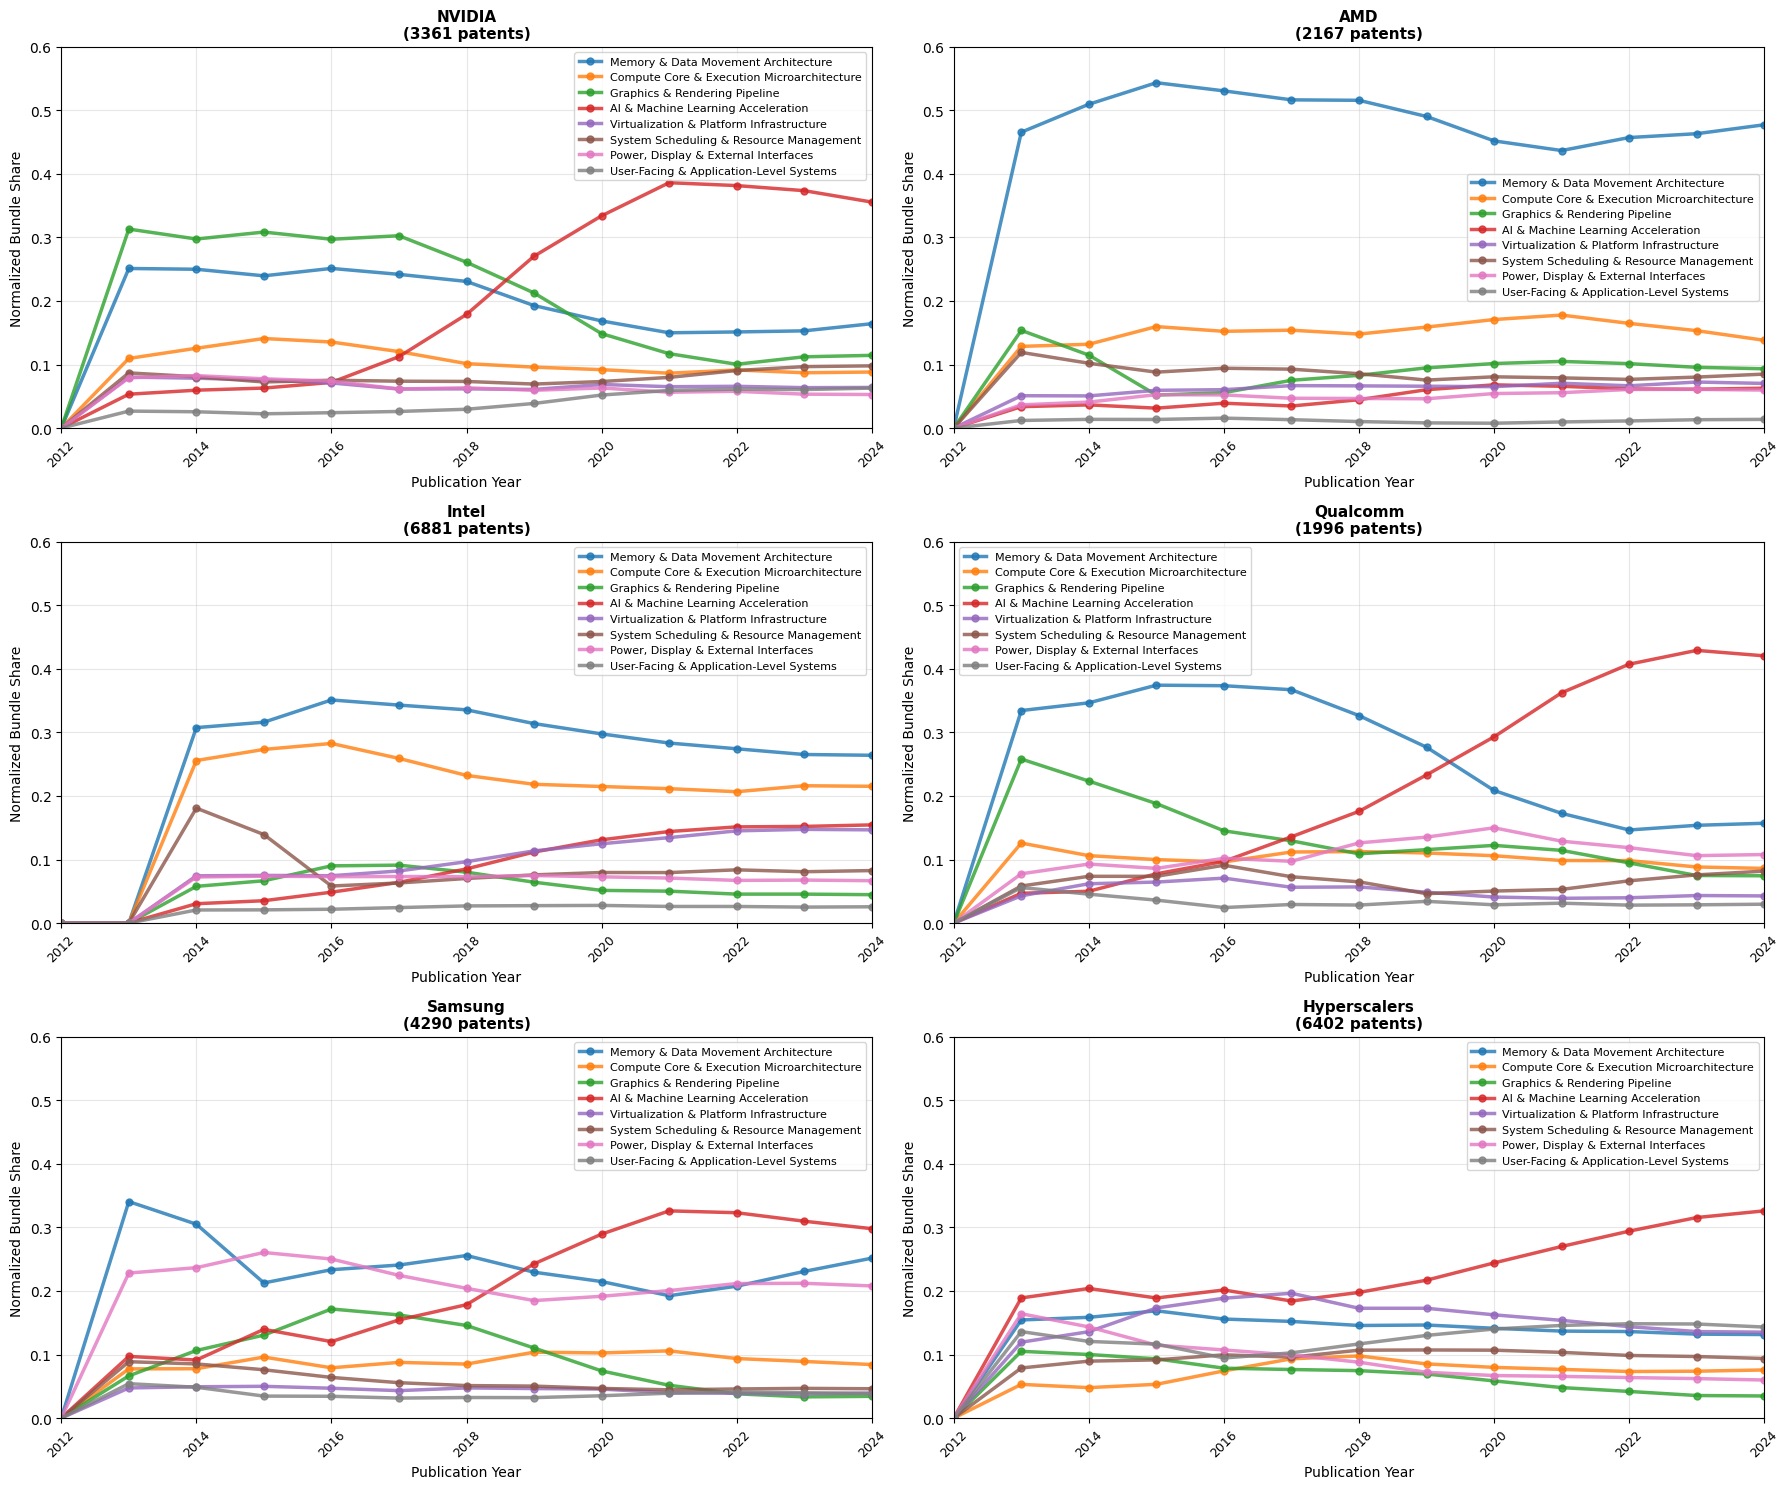


COMPANY-SPECIFIC TOPIC EVOLUTION ANALYSIS

NVIDIA (3361 patents):
  Memory & Data Movement Architecture: decreasing (r=-0.174)
  Compute Core & Execution Microarchitecture: decreasing (r=-0.154)
  Graphics & Rendering Pipeline: decreasing (r=-0.269)
  AI & Machine Learning Acceleration: increasing (r=0.376)
  Virtualization & Platform Infrastructure: decreasing (r=-0.024)
  System Scheduling & Resource Management: increasing (r=0.057)
  Power, Display & External Interfaces: decreasing (r=-0.092)
  User-Facing & Application-Level Systems: increasing (r=0.138)
  Publication range: 2006-2024
  Dominant focus: AI & Machine Learning Acceleration (total share: 921.396)

AMD (2167 patents):
  Memory & Data Movement Architecture: decreasing (r=-0.047)
  Compute Core & Execution Microarchitecture: decreasing (r=-0.015)
  Graphics & Rendering Pipeline: decreasing (r=-0.000)
  AI & Machine Learning Acceleration: increasing (r=0.081)
  Virtualization & Platform Infrastructure: increasing (r=0.045

In [206]:
# Analyze specific patent owners and their topic evolution over time
import matplotlib.pyplot as plt

# Clean and standardize owner names
df_owner = df_filtered.copy()
df_owner['Clean_Owner'] = df_owner['Applicants'].str.split(';').str[0].str.strip()

# Define specific companies to analyze
target_companies = {
    'NVIDIA': ['NVIDIA', 'Nvidia', 'nvidia'],
    'AMD': ['AMD', 'Advanced Micro Devices', 'ADVANCED MICRO DEVICES'],
    'Intel': ['Intel', 'INTEL'],
    'Qualcomm': ['Qualcomm', 'QUALCOMM'],
    'Samsung': ['Samsung', 'SAMSUNG'],
    'Hyperscalers': ['Google', 'Amazon', 'Microsoft', 'GOOGLE', 'AMAZON', 'MICROSOFT', 'Alphabet']
}

# Function to map owner to target company
def map_to_target_company(owner_name):
    if pd.isna(owner_name):
        return None
    for target, variants in target_companies.items():
        for variant in variants:
            if variant in owner_name:
                return target
    return None

# Map owners to target companies
df_owner['Target_Company'] = df_owner['Clean_Owner'].apply(map_to_target_company)

# Get patent counts for target companies
target_patent_counts = df_owner['Target_Company'].value_counts()
print("Patent Counts for Target Companies (2005-2023):")
for company in ['NVIDIA', 'AMD', 'Intel', 'Qualcomm', 'Samsung', 'Hyperscalers']:
    count = target_patent_counts.get(company, 0)
    print(f"  {company}: {count} patents")

# Create figure with subplots - 3 rows, 2 columns for topic evolution
fig = plt.figure(figsize=(18, 15))

# Use the same topic bundles from macro-domain analysis
topic_bundles = {
    "Memory & Data Movement Architecture": [1, 3, 10, 11, 13],
    "Compute Core & Execution Microarchitecture": [2, 4, 8],
    "Graphics & Rendering Pipeline": [7, 19],
    "AI & Machine Learning Acceleration": [5, 6, 15],
    "Virtualization & Platform Infrastructure": [12, 18],
    "System Scheduling & Resource Management": [0, 16],
    "Power, Display & External Interfaces": [9, 14],
    "User-Facing & Application-Level Systems": [17]
}


# Define colors for the 8 bundles
bundle_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Define fixed year range for all plots - starting from 2012
fixed_years = list(range(2012, 2025))  # 2012-2024

# Plot topic evolution for each target company (6 subplots in 3x2 grid)
for idx, company in enumerate(['NVIDIA', 'AMD', 'Intel', 'Qualcomm', 'Samsung', 'Hyperscalers']):
    ax = plt.subplot(3, 2, idx + 1)
    
    # Filter data for this company
    company_data = df_owner[df_owner['Target_Company'] == company]
    patent_count = len(company_data)
    
    # Always plot for all fixed years, showing 0 when no data
    for bundle_idx, (bundle_name, topics) in enumerate(topic_bundles.items()):
        # Initialize with zeros for all fixed years
        bundle_values = []
        
        for year in fixed_years:
            year_data = company_data[company_data['Publication Year'] == year]
            
            if len(year_data) >= 2:  # Only process if sufficient data
                # Calculate bundle total for this year
                bundle_topic_cols = [f'topic_{topic_id}' for topic_id in topics]
                year_bundle_total = year_data[bundle_topic_cols].sum(axis=1).mean()
                
                # Calculate all bundle totals for normalization
                all_bundle_totals_year = 0
                for norm_bundle_name, norm_topics in topic_bundles.items():
                    norm_bundle_cols = [f'topic_{topic_id}' for topic_id in norm_topics]
                    all_bundle_totals_year += year_data[norm_bundle_cols].sum(axis=1).mean()
                
                # Normalize (avoid division by zero)
                if all_bundle_totals_year > 0:
                    normalized_value = year_bundle_total / all_bundle_totals_year
                else:
                    normalized_value = 0
                    
                bundle_values.append(normalized_value)
            else:
                # No data or insufficient data for this year
                bundle_values.append(0)
        
        # Apply light smoothing only to non-zero sections
        bundle_values_series = pd.Series(bundle_values, index=fixed_years)
        # Only smooth where we have actual data (non-zero values)
        non_zero_mask = bundle_values_series > 0
        if non_zero_mask.sum() >= 3:  # Only smooth if we have at least 3 non-zero points
            smoothed_values = bundle_values_series.copy()
            smoothed_values[non_zero_mask] = bundle_values_series[non_zero_mask].rolling(window=3, center=True, min_periods=1).mean()
            bundle_values = smoothed_values.tolist()
        
        # Plot the line for this bundle
        ax.plot(fixed_years, bundle_values, 
                marker='o', linewidth=2.5, markersize=5, 
                label=bundle_name, color=bundle_colors[bundle_idx], alpha=0.8)
    
    # Set consistent formatting for all subplots
    ax.set_xlabel('Publication Year', fontsize=10)
    ax.set_ylabel('Normalized Bundle Share', fontsize=10)
    ax.set_title(f'{company}\n({patent_count} patents)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # Fixed axis ranges for consistency - 2012-2024 x-axis, 0-0.6 y-axis
    ax.set_xlim(2012, 2024)
    ax.set_ylim(0, 0.6)  # Fixed y-axis from 0 to 0.6
    
    # Set x-axis ticks for better readability
    ax.set_xticks(range(2012, 2025, 2))  # Every 2 years from 2012
    ax.tick_params(axis='x', rotation=45, labelsize=9)

plt.tight_layout()
plt.show()

# Print detailed analysis for each target company
print("\n" + "="*80)
print("COMPANY-SPECIFIC TOPIC EVOLUTION ANALYSIS")
print("="*80)

for company in ['NVIDIA', 'AMD', 'Intel', 'Qualcomm', 'Samsung', 'Hyperscalers']:
    company_data = df_owner[df_owner['Target_Company'] == company]
    patent_count = len(company_data)
    
    print(f"\n{company.upper()} ({patent_count} patents):")
    
    if patent_count == 0:
        print("  No patents found in dataset")
        continue
    
    # Calculate bundle trends for this company
    for bundle_name, topics in topic_bundles.items():
        bundle_topic_cols = [f'topic_{topic_id}' for topic_id in topics]
        
        # Only calculate trends if company has multiple years of data
        if len(company_data['Publication Year'].unique()) > 1:
            company_bundle_sum = company_data[bundle_topic_cols].sum(axis=1)
            correlation = company_data['Publication Year'].corr(company_bundle_sum)
            trend_direction = "increasing" if correlation > 0 else "decreasing"
            
            print(f"  {bundle_name}: {trend_direction} (r={correlation:.3f})")
        else:
            print(f"  {bundle_name}: insufficient temporal data")
    
    # Show publication year range for this company
    if patent_count > 0:
        year_range = f"{company_data['Publication Year'].min()}-{company_data['Publication Year'].max()}"
        print(f"  Publication range: {year_range}")
        
        # Show dominant topic bundle for this company (using sum)
        company_bundle_totals = {}
        for bundle_name, topics in topic_bundles.items():
            bundle_topic_cols = [f'topic_{topic_id}' for topic_id in topics]
            company_bundle_totals[bundle_name] = company_data[bundle_topic_cols].sum().sum()
        
        dominant_bundle = max(company_bundle_totals.items(), key=lambda x: x[1])
        print(f"  Dominant focus: {dominant_bundle[0]} (total share: {dominant_bundle[1]:.3f})")

print(f"\n📈 Ready for competitive analysis framework")
print(f"✅ Corporate innovation strategies revealed")
print(f"✅ Topic bundle evolution tracked per company")
print(f"✅ 6 key GPU companies/groups analyzed")
print(f"✅ Fixed axes: x-axis (2012-2024), y-axis (0-0.6) with flat lines at 0 for missing data")
print(f"\n🎯 COMPANY ANALYSIS COMPLETE")

## Bundle-Specific Company Comparison

Compare how different companies focus on each topic bundle relative to the overall market trend.

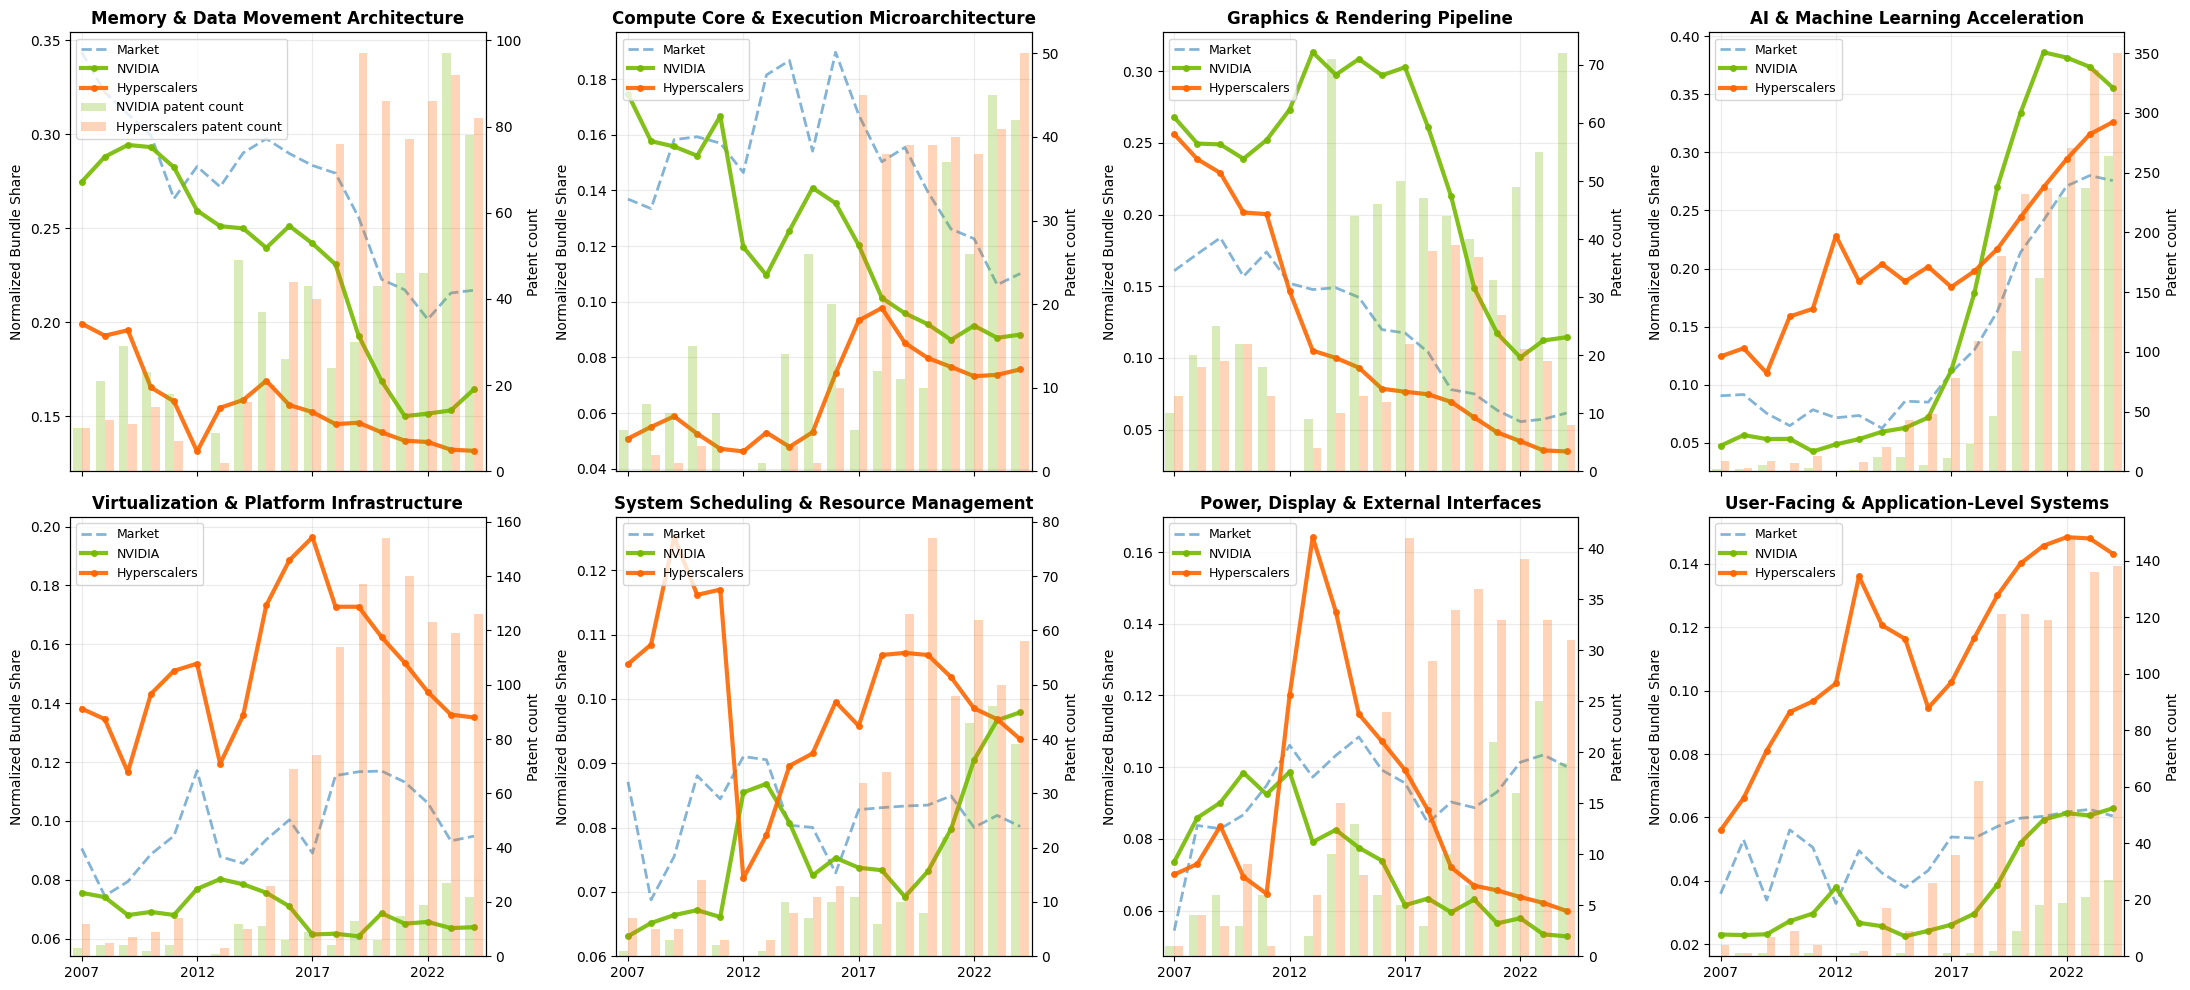

In [207]:
# Bundle-specific comparison charts (lines) + dual-axis patent COUNT bars
# 8 bundles | NVIDIA vs Hyperscalers | 2007–2024 | x-axis ticks every 5 years

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Config
# ----------------------------
focus_companies = ["NVIDIA", "Hyperscalers"]
company_colors = {"NVIDIA": "#76b900", "Hyperscalers": "#ff6600"}

START_YEAR, END_YEAR = 2007, 2024
YEARS = np.arange(START_YEAR, END_YEAR + 1)
XTICKS_5Y = np.arange(START_YEAR, END_YEAR + 1, 5)

# Assumes these exist:
# df_filtered, df_owner, topic_cols, topic_bundles (NOW 8 bundles)

# ----------------------------
# Filter base frames to 2007–2024
# ----------------------------
df_f = df_filtered[(df_filtered["Publication Year"] >= START_YEAR) & (df_filtered["Publication Year"] <= END_YEAR)].copy()
df_o = df_owner[(df_owner["Publication Year"] >= START_YEAR) & (df_owner["Publication Year"] <= END_YEAR)].copy()

# ----------------------------
# Market yearly means (for market baseline line, optional)
# ----------------------------
yearly_topic_means_market = (
    df_f.groupby("Publication Year")[topic_cols]
       .mean()
       .reindex(YEARS)
)

def normalized_bundle_share(yearly_means: pd.DataFrame, topic_bundles: dict, bundle_name: str) -> pd.Series:
    """Bundle share normalized by sum of all bundles (on a yearly means table)."""
    bundle_cols = [f"topic_{t}" for t in topic_bundles[bundle_name]]
    bundle_total = yearly_means[bundle_cols].sum(axis=1)

    denom = pd.Series(0.0, index=yearly_means.index)
    for _, tids in topic_bundles.items():
        cols = [f"topic_{t}" for t in tids]
        denom = denom + yearly_means[cols].sum(axis=1)

    denom = denom.replace(0, np.nan)
    return (bundle_total / denom).fillna(0.0)

# ----------------------------
# Patent COUNTs per bundle (key change)
# Rule: Assign EACH patent to exactly ONE bundle = argmax over bundle-weight (sum topic probs in that bundle).
# Then count patents per year per company per bundle.
# ----------------------------
bundle_names = list(topic_bundles.keys())

# Build bundle score columns on df_o
bundle_score_cols = []
for b in bundle_names:
    cols = [f"topic_{t}" for t in topic_bundles[b]]
    score_col = f"__bundle_score__{b}"
    df_o[score_col] = df_o[cols].sum(axis=1)
    bundle_score_cols.append(score_col)

df_o["Top_Bundle"] = df_o[bundle_score_cols].idxmax(axis=1).str.replace("__bundle_score__", "", regex=False)

def counts_by_year(company_df: pd.DataFrame, bundle_name: str) -> pd.Series:
    """Count of patents per year whose Top_Bundle == bundle_name."""
    s = (
        company_df[company_df["Top_Bundle"] == bundle_name]
        .groupby("Publication Year")
        .size()
        .reindex(YEARS)
        .fillna(0)
        .astype(int)
    )
    return s

# ----------------------------
# Plot: 2x4 grid for 8 bundles
# ----------------------------
fig, axes = plt.subplots(2, 4, figsize=(22, 10), sharex=True)
axes = axes.flatten()

bar_width = 0.38
x = YEARS.astype(float)
offsets = {focus_companies[0]: -bar_width / 2, focus_companies[1]: +bar_width / 2}

for i, bundle_name in enumerate(bundle_names):
    ax = axes[i]
    ax2 = ax.twinx()

    # (Optional) market baseline line
    market_line = normalized_bundle_share(yearly_topic_means_market, topic_bundles, bundle_name)
    ax.plot(
        YEARS, market_line.values,
        linestyle="--", linewidth=2, alpha=0.55, label="Market"
    )

    # Company lines + patent COUNT bars
    for company in focus_companies:
        cdf = df_o[df_o["Target_Company"] == company].copy()
        if len(cdf) == 0:
            continue

        # Line: normalized bundle share from yearly means (smoothed lightly)
        yearly_means_c = (
            cdf.groupby("Publication Year")[topic_cols]
               .mean()
               .reindex(YEARS)
               .rolling(window=3, center=True, min_periods=1)
               .mean()
        )
        line = normalized_bundle_share(yearly_means_c, topic_bundles, bundle_name)
        ax.plot(
            YEARS, line.values,
            linewidth=3, alpha=0.9, color=company_colors[company],
            marker="o", markersize=4, label=company
        )

        # Bars: patent COUNTS assigned to this bundle
        cnt = counts_by_year(cdf, bundle_name)
        ax2.bar(
            x + offsets[company],
            cnt.values,
            width=bar_width,
            alpha=0.28,
            color=company_colors[company],
            label=f"{company} patent count" if i == 0 else None
        )

    # Formatting
    ax.set_title(bundle_name, fontweight="bold")
    ax.set_ylabel("Normalized Bundle Share")
    ax.grid(True, alpha=0.25)

    ax2.set_ylabel("Patent count")

    ax.set_xlim(START_YEAR - 0.5, END_YEAR + 0.5)
    ax.set_xticks(XTICKS_5Y)
    ax.set_xticklabels([str(y) for y in XTICKS_5Y])

    # Keep legends sane: show full legend only on first subplot
    if i == 0:
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax.legend(h1 + h2, l1 + l2, loc="upper left", fontsize=9)
    else:
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, l, loc="upper left", fontsize=9)

plt.tight_layout()
plt.show()
